Выполнила: Анастасия Плавина

## Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

In [1]:
import pandas as pd

#предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
import scipy

from razdel import tokenize
import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

#### Подготовка текстов

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-7-2b1de38ed3a9>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 34.1 s, sys: 480 ms, total: 34.6 s
Wall time: 39.5 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 49s, sys: 2.04 s, total: 4min 51s
Wall time: 5min 14s


In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]
# joined_txts = [' '.join(t) for t in texts]

In [11]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [12]:
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(joined_txts)
# X.toarray()

In [13]:
# from sklearn.feature_extraction.text import TfidfTransformer

# transformer = TfidfTransformer(smooth_idf=False)
# TfidfTransformer(smooth_idf=False)


# tfidf = transformer.fit_transform(X.toarray())
# tfidf.toarray()

#### Обучение модели LDA

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 11s, sys: 4.24 s, total: 1min 16s
Wall time: 1min 3s


In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 12s, sys: 4.14 s, total: 1min 16s
Wall time: 1min 1s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

#### Формируем темы и получаем вектор значений (вероятности принадлежности каждой теме) для каждого документа

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.5657571),
 (2, 0.077026255),
 (6, 0.07677468),
 (7, 0.037063763),
 (9, 0.055715032),
 (11, 0.03404201),
 (12, 0.03248938),
 (13, 0.10305046)]

In [18]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: тело взрыв мужчина женщина обнаружить жертва производитель
topic_1: смерть nn рак газета первый форум общество
topic_2: журнал статья станция nn сайт сократиться бомба
topic_3: всё жизнь ребёнок новый очень большой возраст
topic_4: пенсия мышь лекарство рейтинг компьютерный этаж балл
topic_5: ракета конкурс проект кремль объект супруг строительство
topic_6: кровь рекомендовать фотография задолженность долг популярный австралия
topic_7: египет захватить армия ввс район nn транспорт
topic_8: россия сша американский первый российский nn центр
topic_9: земля район nn место первый граница пострадать
topic_10: день глава государство nn часть около дом
topic_11: китай высота китайский японский япония употребление остров
topic_12: млрд млн рубль тыс исследование пациент составить
topic_13: рынок система экономика банк рост новый снижение
topic_14: турция турецкий лаборатория газ расследование задержать добавлять
topic_15: украина военный украинский киев сша вирус боевой
topic_16: науч

In [19]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.073911,0.036190,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.870159,0.0,0.0,0.011696,0.000000,0.0
1,4896,0.489745,0.486035,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.000000,0.565779,0.077054,0.000000,0.0,0.0,0.076803,0.037104,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,4898,0.000000,0.209375,0.000000,0.407571,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,4899,0.000000,0.154474,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.214836,0.0,0.045196,0.271759,0.0,0.0,0.174683,0.116649,0.0


### 2. Векторные представления пользователей на основе векторов статей, которые они читали

In [21]:
# датасет со статьями юзеров
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
# датасет для проверки оттока
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [23]:
def get_user_embedding(user_articles_list, metric):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = metric(user_vector, 0)
    return user_vector

In [24]:
def pred_churn_by_embedding(users, metric, churn):
    """эмбединг по заданной метрике и оценка работы модели по предсказанию оттока на основе эмбеддинга"""
    
    user_embeddings = pd.DataFrame([i for i in users['articles'] \
                                     .apply(lambda x: get_user_embedding(x, metric), 1)])

    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]


    # джоиним датасет с показателем оттока
    X = pd.merge(user_embeddings, churn, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    #обучение модели
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]


    
    # оценка метрик
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)

    # locate the index of the largest f score
    ix = np.argmax(fscore)

    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f\n' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                        precision[ix],
                                                                           recall[ix]))
    #roc_auc
    rocauc = roc_auc_score(y_test, preds)
    print(f'ROC_AUC: {rocauc}\n')
    
    # сохраняем метрики
    metrics = {'roc_auc': rocauc, 'precision': precision[ix], 'recall': recall[ix], 'f_score': fscore[ix]}
    
    
    # матрица
    font = {'size' : 12}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(8, 5))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    
    return metrics

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 3. Обучим модель предсказания оттока на основе векторов пользователей

In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

by mean vector:
Best Threshold=0.262908, F-Score=0.648, Precision=0.650, Recall=0.645

ROC_AUC: 0.9401314029885459

Confusion matrix, without normalization
[[1670   85]
 [  88  157]]


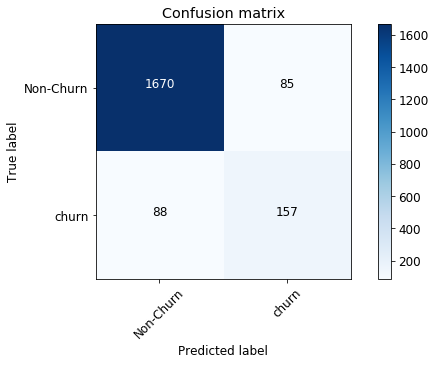

by median vector:
Best Threshold=0.238206, F-Score=0.749, Precision=0.672, Recall=0.845

ROC_AUC: 0.9647165532879817

Confusion matrix, without normalization
[[1654  101]
 [  39  206]]


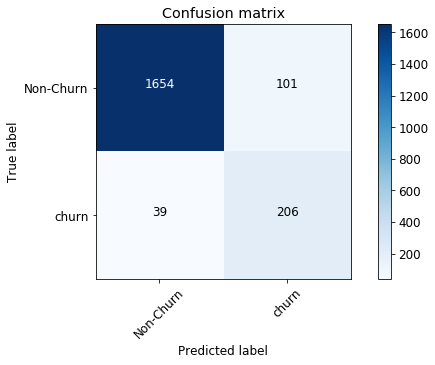

by max vector:
Best Threshold=0.404375, F-Score=0.831, Precision=0.838, Recall=0.824

ROC_AUC: 0.9809174952032095

Confusion matrix, without normalization
[[1716   39]
 [  44  201]]


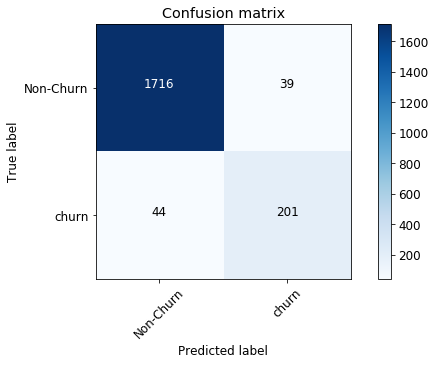

In [27]:
print(f'by mean vector:')
preds_by_mean = pred_churn_by_embedding(users, np.mean, target)
print(f'by median vector:')
preds_by_med = pred_churn_by_embedding(users, np.median, target)
print(f'by max vector:')
preds_by_max = pred_churn_by_embedding(users, np.max, target)

Видим, что при расчете эмбеддинга по максимальному вектору пользователя удалось оптимизировать precisison - то есть мы меньше объектов нулевого класса (оставшиеся на сайте) отнесли к 1 классу (оттекшие). Соответственно, получаем более высокий ROC_AUC на последней модели. 

При этом recall существенно выше на последних двух моделях. Лучший результат - стабильно не выявляем около 20% процентов оттока пользователей. 

In [29]:
# Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: 
# mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
    
df_metrics = pd.DataFrame()

for obj in [preds_by_mean, preds_by_med, preds_by_max]:
    df_obj = pd.DataFrame.from_dict(data=obj,orient='index')
    df_metrics = df_metrics.append(df_obj.T)
    
    
df_metrics.index = ['mean', 'median', 'max']
df_metrics

,roc_auc,precision,recall,f_score
mean,0.940131,0.650206,0.644898,0.647541
median,0.964717,0.672078,0.844898,0.748644
max,0.980917,0.838174,0.824490,0.831276
